In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter
import utils

In [13]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period

In [2]:
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open(best_restult, "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [3]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


In [6]:
def exp_moving_avg(matrix, alpha):
    # Create an empty array for the result
    result = np.zeros_like(matrix)
    
    # Initialize the moving average with the first element of the matrix
    moving_avg = matrix[0]
    
    # Iterate over the matrix and calculate the moving average for each element
    for i in range(matrix.shape[0]):
        # Calculate the moving average for the current element
        moving_avg = alpha * matrix[i] + (1 - alpha) * moving_avg
        
        # Store the moving average in the result array
        result[i] = moving_avg
    
    return result



In [60]:
import numpy as np

def triple_exp_moving_avg(matrix, alpha, beta, gamma):
    # Create an empty array for the result
    result = np.zeros_like(matrix)
    
    # Initialize the moving averages with the first element of the matrix
    SMA = matrix[0]
    EMA1 = matrix[0]
    EMA2 = matrix[0]
    
    # Iterate over the matrix and calculate the moving averages for each element
    for i in range(matrix.shape[0]):
        # Calculate the simple moving average for the current element
        SMA = (1 / 3) * (matrix[i] + matrix[i-1] + matrix[i-2])
        
        # Calculate the first exponential moving average for the current element
        EMA1 = alpha * matrix[i] + (1 - alpha) * EMA1
        
        # Calculate the second exponential moving average for the current element
        EMA2 = beta * EMA1 + (1 - beta) * EMA2
        
        # Calculate the triple exponential moving average for the current element
        triple_EMA = gamma * EMA2 + (1 - gamma) * SMA
        
        # Store the triple exponential moving average in the result array
        result[i] = triple_EMA
    
    return result

# Define the matrix
matrix = np.random.rand(600, 256, 256)

# Define the alpha, beta, and gamma parameters for the triple exponential moving average
alpha = 0.1
beta = 0.1
gamma = 0.1

# Calculate the triple exponential moving average
result = triple_exp_moving_avg(matrix, alpha, beta, gamma)

In [53]:
import numpy as np
from scipy.stats import norm
import math


def detect_2d_cfar(measurements, guard_cells, training_cells, pfa):
    # Calculate the number of training cells
    num_training_cells = (2 * training_cells + 1) * (2 * training_cells + 1) - (2 * guard_cells + 1) * (2 * guard_cells + 1)
    
    # Create a padding around the measurements array to handle edge cases
    padded_measurements = np.pad(measurements, training_cells + guard_cells, mode="edge")
    # Create an empty array for the CFAR result
    cfar_result = np.zeros_like(measurements)
    
    # Iterate over the measurements array and perform CFAR detection for each cell
    for i in range(measurements.shape[0]):
        for j in range(padded_measurements.shape[1]):
            # Extract the training cells
            training_cells = padded_measurements[i:i+2*guard_cells+1, j:j+2*guard_cells+1]

            # Extract the guard cells
            guard_cells = training_cells[0:guard_cells, 0:guard_cells]
            guard_cells += training_cells[0:guard_cells, 2*guard_cells+1:]
            guard_cells += training_cells[2*guard_cells+1:, 0:guard_cells]
            guard_cells += training_cells[2*guard_cells+1:, 2*guard_cells+1:]

            # Compute the average of the training cells
            avg = np.sum(training_cells) - np.sum(guard_cells)
            avg /= num_training_cells
            std_noise_level = np.std(np.abs())
            
            # Calculate the CFAR threshold based on the specified PFA
            threshold = norm.ppf(1 - pfa, avg, std_noise_level)
            
            # Perform CFAR detection on the current cell
            print(np.abs(padded_measurements[i, j]) ,threshold)
            if np.abs(padded_measurements[i, j]) >= threshold:
                print("det")
                cfar_result[i, j] = 1
    
    return cfar_result

In [55]:
def ca_cfar(radar_image, guard_cells, training_cells, pfa):
    # Step 1: Apply a window of size (2 * guard_cells + 1) x (2 * guard_cells + 1) to the input image
    # to suppress the noise and false alarms around the cell under test (CUT).
    window = np.ones((2 * guard_cells + 1, 2 * guard_cells + 1))
    radar_image = np.abs(radar_image) * window

    # Step 2: Compute the average of the noise level in the training cells.
    # The training cells are the cells that are located outside the guard cells.
    # They are used to estimate the noise level in the image.
    training_cells_sum = np.sum(radar_image[guard_cells: -guard_cells, guard_cells: -guard_cells])
    training_cells_avg = training_cells_sum / training_cells

    # Step 3: Compute the threshold value based on the probability of false alarm.
    # The threshold value is the minimum value that a CUT cell must have in order to be considered a potential target.
    # It is calculated as the inverse of the cumulative distribution function (CDF) of the noise level in the training cells.
    threshold = np.sqrt(-2 * np.log(pfa)) * training_cells_avg

    # Step 4: Compare the CUT cell value with the threshold value.
    # If the CUT cell value is greater than the threshold, then it is considered a potential target.
    radar_image[guard_cells: -guard_cells, guard_cells: -guard_cells] = radar_image[guard_cells: -guard_cells, guard_cells: -guard_cells] >= threshold

    # Step 5: Return the processed radar image.
    return radar_image


In [78]:
def background_update(frames, alpha=1/128, nr_of_ma=1,window=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        #window = signal.windows.chebwin(256, 100, sym=True)#signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
       #data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        #data_range_baseline = utils.MIT_filter( data_range_baseline)
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM
    raw_frames = MRDM.copy()
    
    MRDM =triple_exp_moving_avg(data_diff,alpha =alpha,beta=alpha,gamma=alpha)
    data_diff = np.abs(raw_frames) -np.abs(MRDM)
   
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    
    return MRDM,raw_frames,data_diff

In [ ]:
import numpy as np

def reduce_noise(matrix, alpha):
    # Create an empty array for the result
    result = np.zeros_like(matrix)
    
    # Initialize the moving average with the first element of the matrix
    moving_avg = matrix[0]
    
    # Iterate over the matrix and calculate the moving average for each element
    for i in range(matrix.shape[0]):
        # Calculate the moving average for the current element
        moving_avg = alpha * matrix[i] + (1 - alpha) * moving_avg
        
        # If the moving average is greater than the next sample, use the moving average,
        # otherwise use the next sample (to reduce noise)
        if i < matrix.shape[0] - 1 and moving_avg > matrix[i+1]:
            result[i] = moving_avg
        else:
            result[i] = matrix[i+1]
    
    return result

# Define the matrix
matrix = np.random.rand(600, 256, 256)

# Define the alpha parameter for the exponential moving average
alpha = 0.1

# Reduce noise in the matrix using exponential moving average
result = reduce_noise(matrix, alpha)


In [61]:
data_ma,raw_t,data_diff = background_update(data_arr[1:-1],nr_of_ma=
0, alpha=1/128,window=signal.windows.hann(256))

(256, 256)


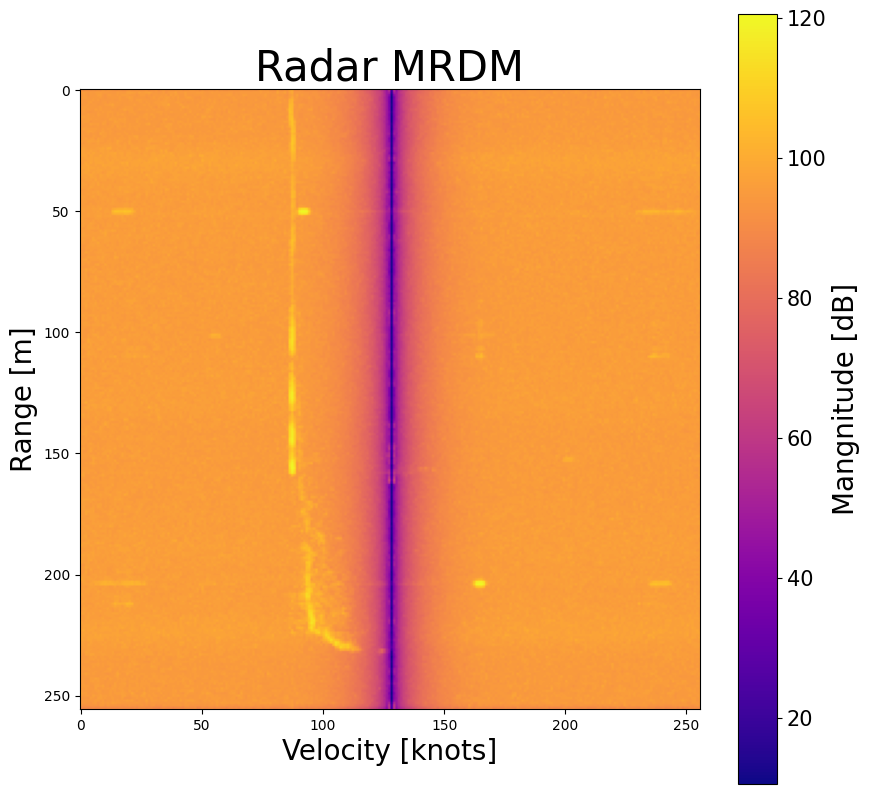

In [ ]:
#%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Radar MRDM"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})

test = np.max(np.abs(data_diff[:500]),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
#test[test>40] =0
rotated_img = ndimage.rotate(test,90)
#rotated_img = np.flip(test,axis=0)
rotated_img =20*np.log10(np.abs(rotated_img)) # We rotate the image so the x axis is the velocity


#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
plt.imshow(rotated_img,cmap="plasma")
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.xlim(80,94)
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("plots/results/radar_MRDM.svg",format="svg")

In [76]:
def all_cfar(data_arr, nr_of_ma=0, alpha=1/256, mode="nearest",window=1 ,plot=False,saveFig=False,FileName="CFAR"):
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=alpha,window = window)
    cfar_array= []
    SNR_array = []
    SNR_D_array = []
    length_data_diff = len(data_diff[:-1])
    for i,img in enumerate( data_diff[:-1]):
        cfar,a,b,c = utils.CFAR_2D(img,10, 15, 0.000001)
        cfar_array.append(cfar)
        print(np.round(i/length_data_diff*100,1))

    labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
    
    test = np.max(np.abs(cfar_array),axis=0)
    plt.figure(figsize=(10,10))
    print(np.shape(test))
    rotated_img =np.abs(test) # We rotate the image so the x axis is the velocity
    
    plt.imshow(rotated_img,cmap="plasma", )
    plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
    cbar  = plt.colorbar()
    cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
    cbar.ax.tick_params(labelsize=15) 
    plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
    plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
    plt.title(labels["title"],fontdict = {'fontsize' : 30})
    plt.grid(False)
    if saveFig:
        plt.savefig(f"plots/results/munkholm_{FileName}.png")
    plt.show()
    return cfar_array

traning area 2160
0.0
traning area 2160
0.3
traning area 2160
0.5
traning area 2160
0.8
traning area 2160
1.0
traning area 2160
1.3
traning area 2160
1.5
traning area 2160
1.8
traning area 2160
2.0
traning area 2160
2.3
traning area 2160
2.5
traning area 2160
2.8
traning area 2160
3.0
traning area 2160
3.3
traning area 2160
3.5
traning area 2160
3.8
traning area 2160
4.0
traning area 2160
4.3
traning area 2160
4.5
traning area 2160
4.8
traning area 2160
5.0
traning area 2160
5.3
traning area 2160
5.5
traning area 2160
5.8
traning area 2160
6.0
traning area 2160
6.3
traning area 2160
6.5
traning area 2160
6.8
traning area 2160
7.0
traning area 2160
7.3
traning area 2160
7.5
traning area 2160
7.8
traning area 2160
8.0
traning area 2160
8.3
traning area 2160
8.5
traning area 2160
8.8
traning area 2160
9.0
traning area 2160
9.3
traning area 2160
9.5
traning area 2160
9.8
traning area 2160
10.0
traning area 2160
10.3
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.0
trani

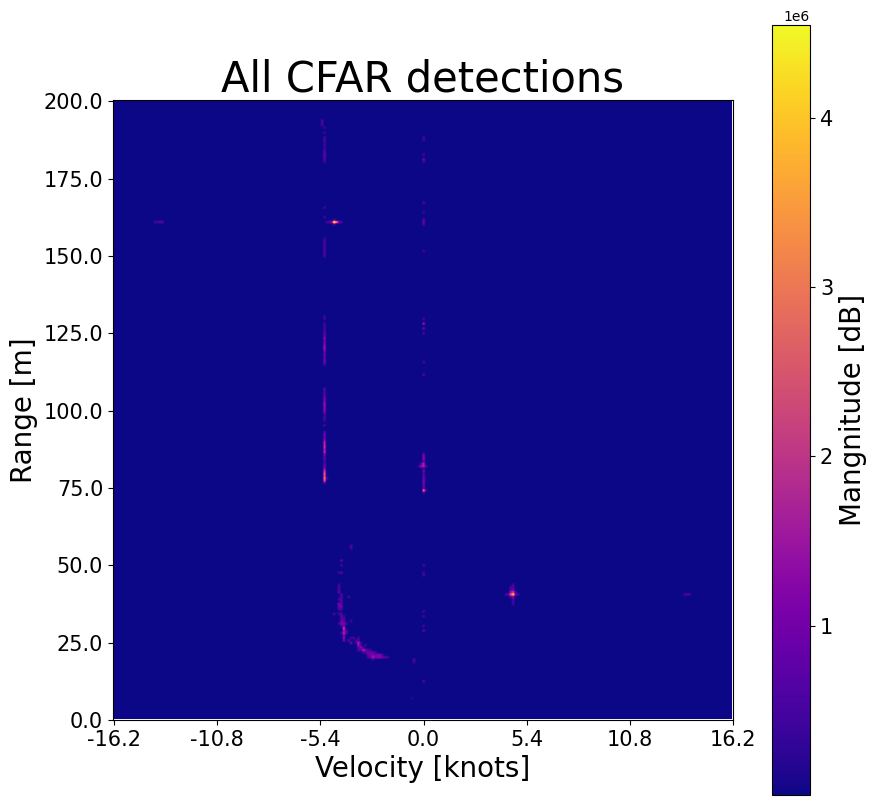

In [79]:
cfar = all_cfar(data_arr=data_arr[100:500], nr_of_ma=0, alpha=1/128, mode="nearest",window=1,plot=False,saveFig=False,FileName="CFAR")

In [72]:
plt.figure()
start_bin =1
end_bin = 157

detections =np.max(np.abs(cfar),axis=0)
print(np.shape(detections))
#detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,87]))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
plt.show()

(256, 256)


TypeError: object of type 'numpy.float64' has no len()

<Figure size 640x480 with 0 Axes>

# Triple expontatil moving average